# 稠密连接网络（DenseNet - Densely Connected Convolutional Network）

DenseNet是一种深度卷积神经网络，以其密集连接的结构而闻名。它通过密集连接块（Dense Block）来促进特征的重用和信息流动，从而在减少参数数量的同时提高了网络的表示能力。

## 背景

在传统的卷积神经网络中，特征在不同层之间的传递是通过浅层到深层的逐层连接实现的。DenseNet引入了密集连接，允许每一层都直接与之前的所有层相连，从而使得信息可以更自由地在网络中传递。

## 密集连接块

DenseNet的核心是密集连接块，它由多个卷积层和连接层组成。在每个密集连接块中，每一层的输出都被连接到前面所有层的输入上。这种密集连接的方式有助于特征的重用和信息的流动，避免了信息在网络中丢失。

## DenseNet的优势

- **特征重用：** 密集连接促使网络在每一层都能重用之前层的特征，有助于提取更丰富的信息。
- **减少参数：** 密集连接块内部共享参数，减少了参数的数量，从而减少了过拟合的风险。
- **抑制梯度消失：** 密集连接使得梯度更容易传播，有助于缓解梯度消失问题。

## DenseNet的结构

DenseNet主要由密集连接块和过渡层（Transition Layer）组成。密集连接块内的卷积层可以有不同的深度，而过渡层用于控制特征图的尺寸，以及将特征图的通道数减少，从而降低计算复杂度。



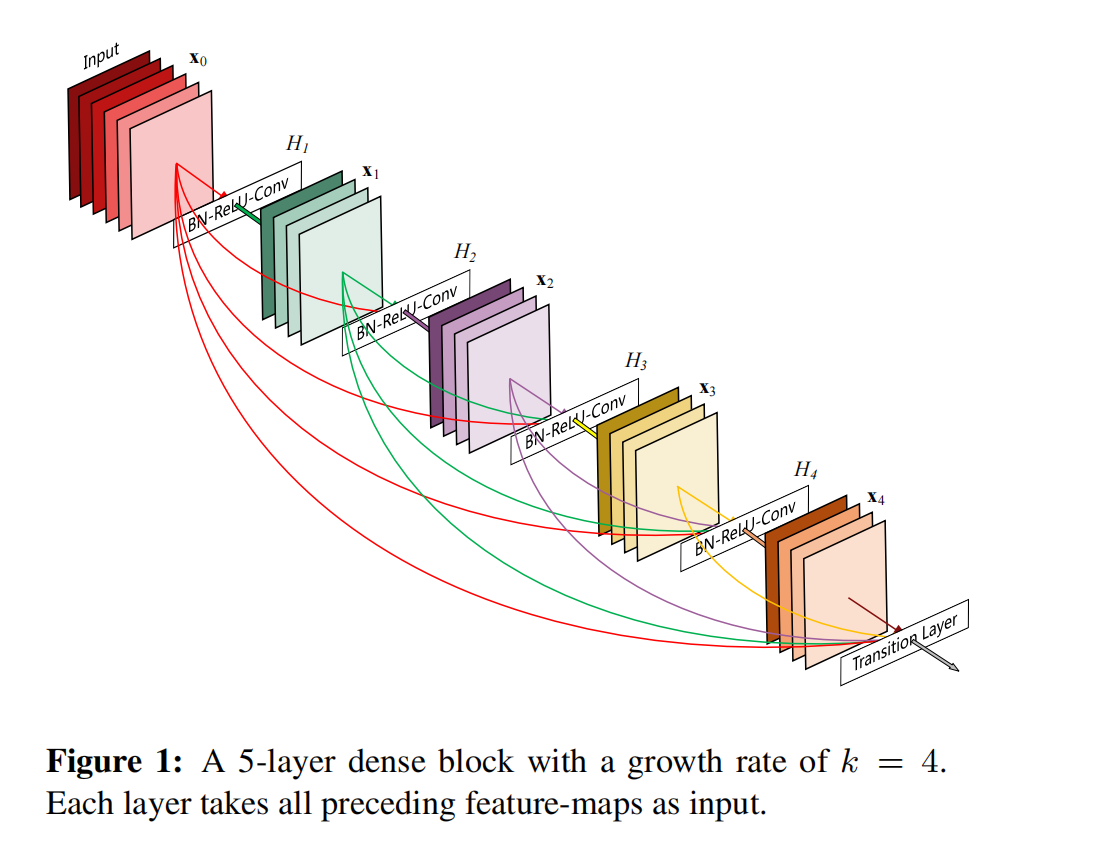

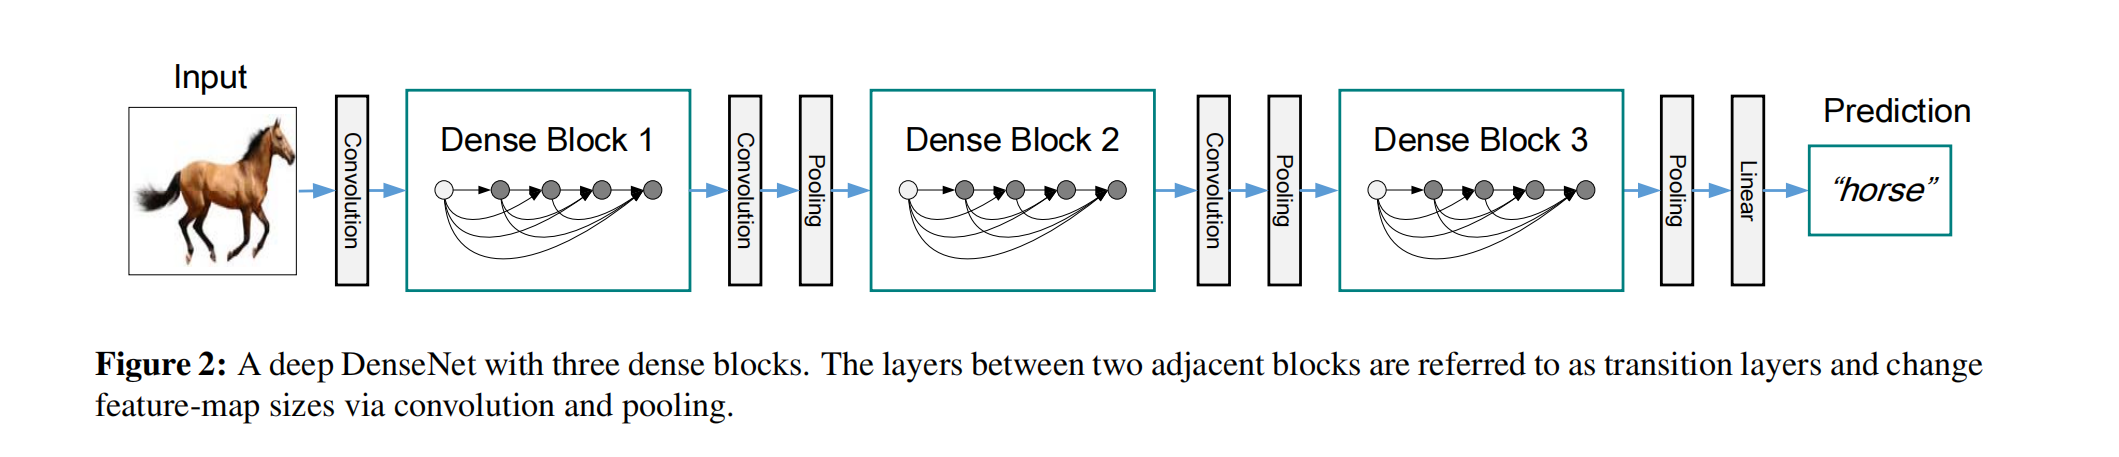

## 稠密块（dense block）

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

def conv_block(input_channels, num_channels):
    """
    定义一个卷积块。
    
    参数：
    - input_channels: 输入通道数。
    - num_channels: 输出通道数（卷积核的数量）。
    
    返回：
    - 卷积块的Sequential模型,包含批量归一化、ReLU激活和卷积层。
    """
    return nn.Sequential(nn.BatchNorm2d(input_channels),  # 批量归一化，提升网络稳定性和训练速度
                         nn.ReLU(),                        # ReLU激活函数，引入非线性变换
                         nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1))  # 3x3卷积层

In [3]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        """
        定义一个Dense块。

        参数：
        - num_convs: 在Dense块内部的卷积层数量。
        - input_channels: 输入通道数。
        - num_channels: 卷积核的数量（输出通道数）。
        """
        super().__init__()
        layer = []
        for i in range(num_convs):
            # 构建卷积块并添加到列表中
            layer.append(conv_block(num_channels * i + input_channels, num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        """
        前向传播函数。

        参数：
        - X: 输入张量。

        返回：
        - 前向传播后的张量。
        """
        for blk in self.net:
            Y = blk(X)
            # 连接通道维度上每个块的输入和输出，使特征在密集连接块内传递
            X = torch.cat((X, Y), dim=1)
        return X

In [4]:
blk = DenseBlock(2, 3, 10)
X = torch.randn(4, 3, 8, 8)
Y = blk(X)
Y.shape

torch.Size([4, 23, 8, 8])

## 过渡层（transition layer）

In [5]:
def transition_block(input_channels, num_channels):
    """
    定义一个过渡块(Transition Block)。

    参数：
    - input_channels: 输入通道数。
    - num_channels: 输出通道数（卷积核的数量）。

    返回：
    - 过渡块的Sequential模型,包含批量归一化、ReLU激活、1x1卷积层和2x2平均池化层。
    """
    return nn.Sequential(nn.BatchNorm2d(input_channels),nn.ReLU(),
                         nn.Conv2d(input_channels, num_channels, kernel_size=1),
                         nn.AvgPool2d(kernel_size=2, stride=2))


In [6]:
blk = transition_block(23, 10)
blk(Y).shape

torch.Size([4, 10, 4, 4])

## DenseNet模型

In [7]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [8]:
# num_channels为当前的通道数
num_channels, growth_rate = 64, 32
num_convs_in_dense_blocks = [4, 4, 4, 4]
blks = []
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    blks.append(DenseBlock(num_convs, num_channels, growth_rate))
    # 上一个稠密块的输出通道数
    num_channels += num_convs * growth_rate
    # 在稠密块之间添加一个转换层，使通道数量减半
    if i != len(num_convs_in_dense_blocks) - 1:
        blks.append(transition_block(num_channels, num_channels // 2))
        num_channels = num_channels // 2

In [9]:
net = nn.Sequential(b1, *blks,
                    nn.BatchNorm2d(num_channels), nn.ReLU(),
                    nn.AdaptiveAvgPool2d((1, 1)),
                    nn.Flatten(),
                    nn.Linear(num_channels, 10))

In [10]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
DenseBlock output shape:	 torch.Size([1, 192, 56, 56])
Sequential output shape:	 torch.Size([1, 96, 28, 28])
DenseBlock output shape:	 torch.Size([1, 224, 28, 28])
Sequential output shape:	 torch.Size([1, 112, 14, 14])
DenseBlock output shape:	 torch.Size([1, 240, 14, 14])
Sequential output shape:	 torch.Size([1, 120, 7, 7])
DenseBlock output shape:	 torch.Size([1, 248, 7, 7])
BatchNorm2d output shape:	 torch.Size([1, 248, 7, 7])
ReLU output shape:	 torch.Size([1, 248, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 248, 1, 1])
Flatten output shape:	 torch.Size([1, 248])
Linear output shape:	 torch.Size([1, 10])


In [24]:
net

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): DenseBlock(
    (net): Sequential(
      (0): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (2): Sequential(
        (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

## 训练模型

KeyboardInterrupt: 

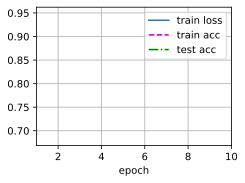

In [9]:
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())